# Model SIMEX

Model SIMEX is introduced in chapter 3 of {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` "Monetary Economics: An Integrated Approach to Credit, Money, Income, Production and Wealth" and represents the "simplest model with government money". That is, this is a model with only _outside money_ (from the government).

## Model Overview

### Behavioral Equations

The SIMEX model is introduced in Chapter 3, and consists of the following 13 equations and 13 unknowns:

1. Consumption good supply equals demand
$$
C_s(t) = C_d(t)
$$
3. Governmend good supply equals demand
$$
G_s(t) = G_d(t)
$$
3. Tax supply equals demand
$$
T_s(t) = T_d(t)
$$
4. Labour supply equals demand
$$
N_s(t) = N_d(t)
$$
5. Disposable income is wage income minus taxes
$$
YD(t) = W(t)\cdot N_s(t) - T_s(t)
$$
6. Tax demand is a fixed proportion of wage income
$$
T_d(t) = \theta\cdot W(t)\cdot N_s(t)
$$
7. Consumption demand is a share of disposable income and deposits
$$
C_d(t) = \alpha_1\cdot YD(t) + \alpha_2\cdot H_h(t-1)
$$
8. The change in government stock of money is demand minus tax
$$
\Delta H_s(t) = H_s(t) - H_s(t-1) = G_d(t) - T_d(t)
$$
9. The change in household deposits is disposable income minus expenditure
$$
\Delta H_h(t) = H_h(t) - H_h(t-1) = YD(t) - C_d(t)
$$
8. Total national income is consumption of households and government
$$
Y(t) = C_s(t) + G_s(t)
$$
8. Labour Demand is national income over wages
$$
N_d(t) = \frac{Y(t)}{W(t)}
$$
9. Households' demand for money is given by the excess of consumption demand over the current level of savings and expected income
$$
\Delta H_d(t) = YD^e(t) - C_d(t)
$$
10. Households' expected disposable income is equal to their prior disposable income
$$
YD^e(t) = YD(t-1)
$$

With the redundant equation being
$$
\Delta H_s(t) = \Delta H_h(t)
$$


## Implementation in MacroStat

Transposing these eleven equations to the `MacroStat` framework, we consider that there are:

1. Three parameters (fixed constants): $\alpha_1$, $\alpha_2$, and $\theta$ (see [Parameters](GL06SIMEX/parameters.rst))
2. Two scenario variables : $G_d(t)$ and $W(t)$ (see [Scenarios](GL06SIMEX/scenarios.rst))
3. The remaining 16 tracked series are variables (see [Variables](GL06SIMEX/variables.rst))

### Behavioral Modeling

Unlike [Model SIM](GL06SIM.ipynb), the determination of consumption demand based on expected disposable income means we do not need to rely on knowing ex ante the multiplier to resolve the model easily. Instead we can simply iterate forward. For a given period $t$ we can solve the system by solving, in order:
1. Eq. {eq}`gl06_simex_eq302_governmentClearing` given the scenario variable
2. Eq. {eq}`gl06_simex_eq320_expectedDisposableIncome`
3. Consumption demand, given disposable income, Eq. {eq}`gl06_simex_eq307_consumptionDemand`
4. Consumption supply, given demand, Eq. {eq}`gl06_simex_eq301_consumptionClearing`
5. National income, Eq. {eq}`gl06_simex_eq310_nationalIncome`
6. Eq. {eq}`gl06_simex_eq311_labourDemand` for labour demand
7. Eq. {eq}`gl06_simex_eq304_labourClearing` for labour supply
8. Tax demand, given labour, Eq. {eq}`gl06_simex_eq306_taxDemand`
9. Tax supply, given demand, Eq. {eq}`gl06_simex_eq303_taxClearing`
10. Disposable income, given labour supply and tax demand, Eq. {eq}`gl06_simex_eq305_disposableIncome`
11. Government stock of money, Eq. {eq}`gl06_simex_eq308_governmentDeposits`
12. Household demand for money, Eq. {eq}`gl06_simex_eq318_householdMoneyDemand`
13. Household stock of deposits, Eq. {eq}`gl06_simex_eq309_householdDeposits`


This is implemented as such in the [Behavior](GL06SIMEX/behavior.rst) class. 

## Model Dynamics

### Preparatory Steps

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from macrostat.models import get_model

### Convergence to the Steady State

In {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` models are initialized with almost all of the variables set to zero. For model SIMEX the only non-zero item is that in period 0 the government demand is 20, i.e. the government creates 20 monetary units of demand. Thereafter the system converges to a steady state. We can see this by simulating the default parameters and checking that total national income is 100. 

In [2]:
GL06SIMEX = get_model("GL06SIMEX")
model = GL06SIMEX()
model.simulate()
output = model.variables.to_pandas()

#### National Income

In [3]:
steady_state_income = model.scenarios[(0,"GovernmentDemand")][0] / model.parameters["TaxRate"]

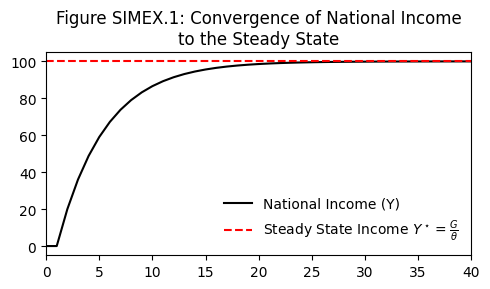

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output.index, output['NationalIncome'], color='k', label='National Income (Y)')
axs.axhline(y=steady_state_income, color='r', linestyle='--', label=r'Steady State Income $Y^\star=\frac{G}{\theta}$')
axs.legend(loc='lower right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIMEX.1: Convergence of National Income\nto the Steady State')
plt.tight_layout()
plt.show()


#### Disposable Income and Consumption

Corresponding to Figure 3.2 "Disposable income and consumption starting from scratch"

In [5]:
steady_state_consumption= (model.scenarios[(0,"GovernmentDemand")][0] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

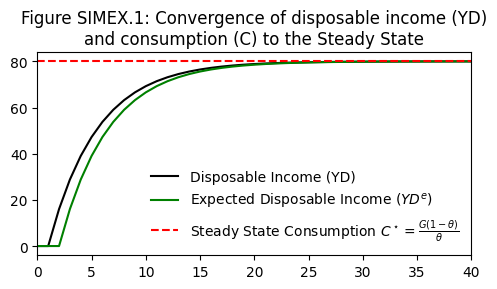

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output.index, output['DisposableIncome'], color='k', label='Disposable Income (YD)')
axs.plot(output.index, output['ExpectedDisposableIncome'], color='g', label='Expected Disposable Income ($YD^e$)')
axs.axhline(y=steady_state_consumption, color='r', linestyle='--', label=r'Steady State Consumption $C^\star=\frac{G(1-\theta)}{\theta}$')
axs.legend(loc='lower right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIMEX.1: Convergence of disposable income (YD)\nand consumption (C) to the Steady State')
plt.tight_layout()
plt.show()


#### Wealth and Savings

Corresponding to Figure 3.3 "Wealth change and wealth level, starting from scratch (Table 3.4)"

In [7]:
alpha3 = (1-model.parameters["PropensityToConsumeSavings"]) / model.parameters["PropensityToConsumeIncome"]
steady_state_wealth = alpha3 * (model.scenarios[(0,"GovernmentDemand")][0] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

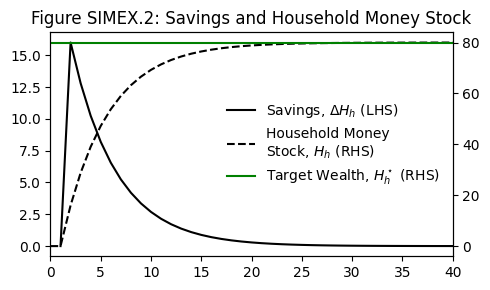

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
line1 = axs.plot(output.index, output['HouseholdMoneyStock'].diff(), color='k', label=r'Savings, $\Delta H_h$ (LHS)')
ax2 = axs.twinx()
line2 = ax2.plot(output.index, output['HouseholdMoneyStock'], color='k', linestyle='--', label='Household Money\n'+r'Stock, $H_h$ (RHS)')
line3 = ax2.axhline(y=steady_state_wealth, color='g', label=r'Target Wealth, $H_h^\star$ (RHS)')
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc='center right', frameon=False)
axs.set_xlim(0,40)
axs.set_title('Figure SIMEX.2: Savings and Household Money Stock')
plt.tight_layout()
plt.show()


### Perturbations in the Steady State

Following the convergence to the steady state, we can introduce a shock in government spending, increasing it by 5 units. Accordingly, the steady state given by $Y^\star=\frac{G}{\theta}$ would shift to $Y^\star=125$

This kind of scenario can easily be implemented in the `MacroStat` version by adding a scenario:
1. Noting that we have convergence to the steady state at period 40, let us set this as the scenario trigger
2. We then need a new timeseries for the scenario, where $G=25$ from the trigger period onwards

In [12]:
model.parameters["scenario_trigger"] = 40
model.scenarios.add_scenario(
    name="GovernmentDemandIncrease",
    timeseries={"GovernmentDemand":25}
)
model.simulate(scenario="GovernmentDemandIncrease")
output_government_demand_increase = model.variables.to_pandas()

#### National Income

In [13]:
steady_state_income_new = model.scenarios[("GovernmentDemandIncrease","GovernmentDemand")][-1] / model.parameters["TaxRate"]

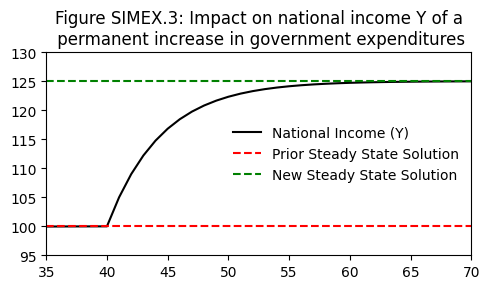

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
axs.plot(output_government_demand_increase['NationalIncome'], color='k', label='National Income (Y)')
axs.axhline(y=steady_state_income, color='r', linestyle='--', label='Prior Steady State Solution')
axs.axhline(y=steady_state_income_new, color='g', linestyle='--', label='New Steady State Solution')
axs.legend(loc='center right', frameon=False)
axs.set_xlim(35,70)
axs.set_ylim(95,130)
axs.set_title('Figure SIMEX.3: Impact on national income Y of a\n permanent increase in government expenditures')
plt.tight_layout()
plt.show()


#### Consumption and Wealth

In [15]:
steady_state_wealth_new = alpha3 * (model.scenarios[("GovernmentDemandIncrease","GovernmentDemand")][-1] * (1-model.parameters["TaxRate"])) / model.parameters["TaxRate"]

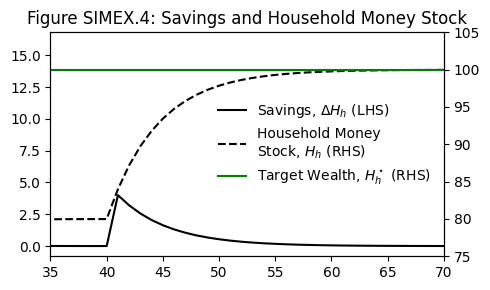

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
line1 = axs.plot(output_government_demand_increase['HouseholdMoneyStock'].diff(), color='k', label=r'Savings, $\Delta H_h$ (LHS)')
ax2 = axs.twinx()
line2 = ax2.plot(output_government_demand_increase['HouseholdMoneyStock'], color='k', linestyle='--', label='Household Money\n'+r'Stock, $H_h$ (RHS)')
line3 = ax2.axhline(y=steady_state_wealth_new, color='g', label=r'Target Wealth, $H_h^\star$ (RHS)')
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc='center right', frameon=False)
axs.set_xlim(35,70)
ax2.set_ylim(75,105)
axs.set_title('Figure SIMEX.4: Savings and Household Money Stock')
plt.tight_layout()
plt.show()
